In [82]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import re
import json
import requests
import openpyxl
import urllib
from urllib import parse
import lxml
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import time
from sklearn.preprocessing import MinMaxScaler

#웹드라이버 설정
options = webdriver.ChromeOptions()
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

In [119]:
def normalize_scale(inp):# 환율데이터 표본적어서 *10
    result = []
    for i in inp:
        result.append(((i-np.mean(inp))/np.var(inp))*10)
    return result
def normalize(inp):# *10안함
    result = []
    for i in inp:
        result.append(((i-np.mean(inp))/np.var(inp)))
    return result

class Stock:
    
    Exchange='./Data/Exchange.csv' #객체가 공통으로 사용할 환율 데이터 (동적크롤링할줄몰라서 csv로 받아옴)
    
    def __init__(self,code):
        self.code=code
    
    @staticmethod
    def exchangeRate():  ##1달간격의 환율의 종가데이터  1행배열 57요소( 18.05.01~  23.01.01) 배열로 출력 SIZE(1,57)
        csv = pd.read_csv(Stock.Exchange,encoding='utf8')
        #print(csv)  환율 전체데이터 확인하기            
        csv = np.array(csv)
        data=[]
        for i in range(len(csv)):   
            fnum=""
            for j in csv[i][1]:
                if(j == ','):
                    continue
                fnum+=j
            data.append(float(fnum))
        data = np.array(data)
        data = data.astype('float32')
        data = normalize_scale(data) 
        return data


    def idxNorm(self):##ROA, ROE, EPS, BPS, DPS, PER, PBR의 각 항목당 (2018.12 ~ 2023.12)의 데이터 6개 갖음 SIZE(7,8)
        get_param = {
            'pGB':1,
            'gicode':'A%s'%(self.code),
            'cID':'',
            'MenuYn':'Y',
            'ReportGB':'',
            'NewMenuID':101,
            'stkGb':701,
        }
        get_param = parse.urlencode(get_param)
        url="http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?%s"%(get_param)
        tables = pd.read_html(url, header=0,encoding='utf-8')
        sit=np.array(tables[11]) 
        data=[]#정규화 시작
        idx=np.array([])
        for i in range(7):
            idx = sit[17+i][2:8].astype('float32')
            idx = normalize(idx)
            data.append(idx)
        data=np.array(data)
        return data
    
    def priceList(self):
        csv = pd.read_csv('./Data/주식가격/%s.csv'%(self.code))
        cut_csv = csv[:][:1148]
        arr = np.array(cut_csv)
        array = arr[:,2]
        array = array/1000
        array = np.array(array)
        close = array.reshape(-1,1)
        return close

    def showChart(self): ##종목코드의 제무재표를 나타내는 함수
        get_param = {
            'pGB':1,
            'gicode':'A%s'%(self.code),
            'cID':'',
            'MenuYn':'Y',
            'ReportGB':'',
            'NewMenuID':101,
            'stkGb':701,
        }
        get_param = parse.urlencode(get_param)
        url="http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?%s"%(get_param)
        tables = pd.read_html(url, header=0,encoding='utf-8')
        return tables[11]

In [120]:
arr = pd.read_csv('./Data/주식가격/005930.csv')
cut_csv = csv[:][:1148]
arr = np.array(cut_csv)
array = arr[:,2]

C:\Users\wjddu\AppData\Local\Temp\ipykernel_11612\2031941233.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  arr = pd.read_csv('./Data/주식가격/005930.csv')


In [121]:
def concatData(a, data):
    a2023 = a[:-1147]
    a2022 = a[-1147:-901]
    a2021 = a[-901:-653]
    a2020 = a[-653:-405]
    a2019 = a[-405:-159]
    a2018 = a[-159:len(sa)]
    
    data2023 = np.full((len(a2023),7), data[:,5])
    data2022 = np.full((len(a2022),7), data[:,4])
    data2021 = np.full((len(a2021),7), data[:,3])
    data2020 = np.full((len(a2020),7), data[:,2])
    data2019 = np.full((len(a2019),7), data[:,1])
    data2018 = np.full((len(a2018),7), data[:,0])
    
    data1 = data2023
    data1 = np.concatenate((np.full((len(a2023),7), data[:,5]),
                            np.full((len(a2022),7), data[:,4]),
                            np.full((len(a2021),7), data[:,3]),
                            np.full((len(a2020),7), data[:,2]),
                            np.full((len(a2019),7), data[:,1]),
                            np.full((len(a2018),7), data[:,0])), axis=0)
    arr = np.concatenate((a, data1), axis=1)
    array = np.array(arr)
    
    er = Stock.exchangeRate()
    er = np.array(er).reshape(-1, 1)
    
    exchange = np.full((1,1), er[-57])
    exchange = np.concatenate((exchange, np.full((21,1), er[-56]),
                               np.full((22,1), er[-55]),
                               np.full((19,1), er[-54]),
                               np.full((20,1), er[-53]),
                               np.full((22,1), er[-52]),
                               np.full((21,1), er[-51]),
                               np.full((20,1), er[-50]),
                               np.full((21,1), er[-49]),
                               np.full((21,1), er[-48]),
                               np.full((21,1), er[-47]),
                               np.full((18,1), er[-46]),
                               np.full((20,1), er[-45]),
                               np.full((22,1), er[-44]),
                               np.full((22,1), er[-43]),
                               np.full((19,1), er[-42]),
                               np.full((19,1), er[-41]),
                               np.full((21,1), er[-40]),
                               np.full((22,1), er[-39]),
                               np.full((22,1), er[-38]),
                               np.full((19,1), er[-37]),
                               np.full((22,1), er[-36]),
                               np.full((22,1), er[-35]),
                               np.full((18,1), er[-34]),
                               np.full((20,1), er[-33]),
                               np.full((21,1), er[-32]),
                               np.full((21,1), er[-31]),
                               np.full((19,1), er[-30]),
                               np.full((21,1), er[-29]),
                               np.full((20,1), er[-28]),
                               np.full((23,1), er[-27]),
                               np.full((22,1), er[-26]),
                               np.full((19,1), er[-25]),
                               np.full((20,1), er[-24]),
                               np.full((22,1), er[-23]),
                               np.full((20,1), er[-22]),
                               np.full((20,1), er[-21]),
                               np.full((20,1), er[-20]),
                               np.full((21,1), er[-19]),
                               np.full((21,1), er[-18]),
                               np.full((19,1), er[-17]),
                               np.full((21,1), er[-16]),
                               np.full((23,1), er[-15]),
                               np.full((19,1), er[-14]),
                               np.full((21,1), er[-13]),
                               np.full((22,1), er[-12]),
                               np.full((20,1), er[-11]),
                               np.full((17,1), er[-10]),
                               np.full((22,1), er[-9]),
                               np.full((19,1), er[-8]),
                               np.full((22,1), er[-7]),
                               np.full((21,1), er[-6]),
                               np.full((17,1), er[-5]),
                               np.full((22,1), er[-4]),
                               np.full((22,1), er[-3]),
                               np.full((19,1), er[-2]),
                               np.full((17,1), er[-1])), axis=0)
    train_inputs = np.concatenate((array, exchange), axis=1)
    return train_inputs
def scaleData(a):
    scaler = MinMaxScaler()
    scale_cols = [0]
    df_scaled = scaler.fit_transform(a[scale_cols])

In [122]:
SS = Stock('005930')
SK = Stock('000660')
DW=Stock('049770')
SFA=Stock('056190')
GW=Stock('001570')

sa=SS.priceList()
sk=SK.priceList()
dw=DW.priceList()
sf=SFA.priceList()
gy=GW.priceList()
sadata=SS.idxNorm()
skdata=SK.idxNorm()
dwdata=DW.idxNorm()
gydata=GW.idxNorm()
sfdata=SFA.idxNorm()

C:\Users\wjddu\AppData\Local\Temp\ipykernel_11612\3473795404.py:62: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  csv = pd.read_csv('./Data/주식가격/%s.csv'%(self.code))
C:\Users\wjddu\AppData\Local\Temp\ipykernel_11612\3473795404.py:62: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  csv = pd.read_csv('./Data/주식가격/%s.csv'%(self.code))


In [170]:
train_inputs = concatData(sa, sadata)
train_labels = train_inputs[1:,0].reshape(-1,1).astype(float)
print(train_labels.shape)
train_inputs = train_inputs[:-1,0].reshape(-1,1).astype(float)
x_train, x_test, y_train, y_test = train_test_split(train_inputs, train_labels, test_size=0.2, shuffle=False)
print(train_inputs)
print(train_labels)

(1147, 1)
[[ 0.2]
 [-1.3]
 [-1.5]
 ...
 [-0.3]
 [ 0.7]
 [-1.7]]
[[-1.3]
 [-1.5]
 [ 0.2]
 ...
 [ 0.7]
 [-1.7]
 [ 0.7]]


In [179]:
model = Sequential([
    layers.LSTM(50, input_shape=(1,1)),
    layers.Dense(1)
    
])
model.compile(loss='mse',optimizer='adam', metrics='accuracy')
model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 50)                10400     
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [180]:
model.fit(x_train, y_train,
    validation_data=(x_test,y_test),
    batch_size=10,
    epochs=20
)

Epoch 1/20
92/92 [==============================] - 4s 12ms/step - loss: 0.9845 - accuracy: 0.0458 - val_loss: 0.5170 - val_accuracy: 0.0435
Epoch 2/20
92/92 [==============================] - 0s 5ms/step - loss: 0.9818 - accuracy: 0.0458 - val_loss: 0.5178 - val_accuracy: 0.0435
Epoch 3/20
92/92 [==============================] - 0s 3ms/step - loss: 0.9809 - accuracy: 0.0458 - val_loss: 0.5185 - val_accuracy: 0.0435
Epoch 4/20
92/92 [==============================] - 0s 3ms/step - loss: 0.9806 - accuracy: 0.0458 - val_loss: 0.5187 - val_accuracy: 0.0435
Epoch 5/20
92/92 [==============================] - 0s 3ms/step - loss: 0.9817 - accuracy: 0.0458 - val_loss: 0.5202 - val_accuracy: 0.0435
Epoch 6/20
92/92 [==============================] - 0s 4ms/step - loss: 0.9804 - accuracy: 0.0458 - val_loss: 0.5191 - val_accuracy: 0.0435
Epoch 7/20
92/92 [==============================] - 0s 3ms/step - loss: 0.9811 - accuracy: 0.0458 - val_loss: 0.5190 - val_accuracy: 0.0435
Epoch 8/20
92/92 [=

8/8 [==============================] - 1s 3ms/step


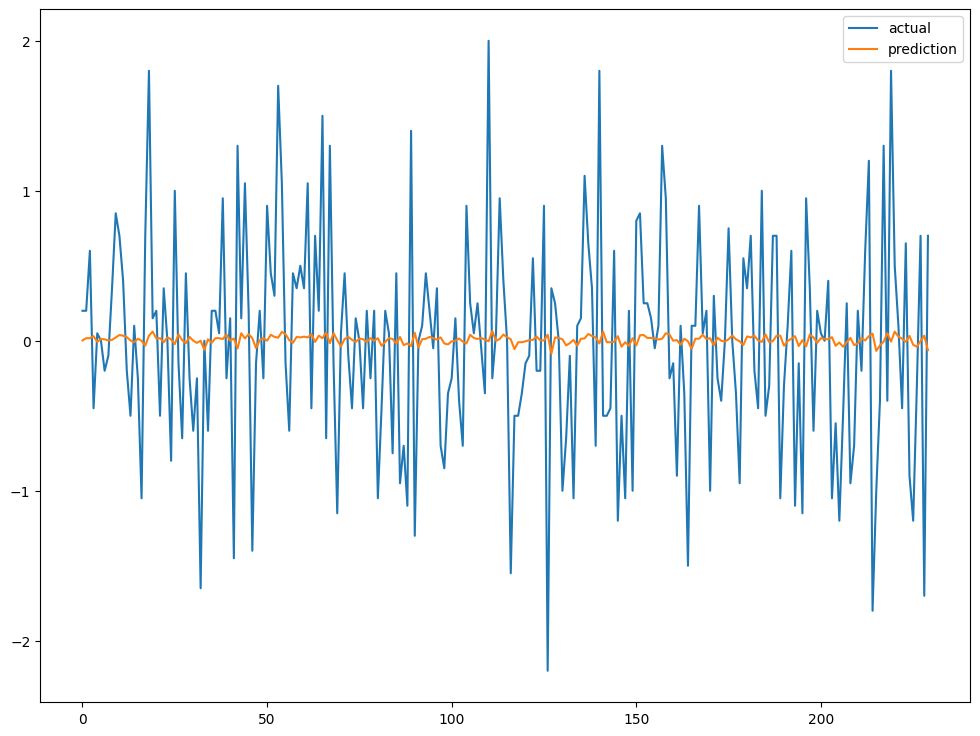

In [181]:
pred = model.predict(x_test)
plt.figure(figsize=(12, 9))
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()